In [1]:
from __future__ import annotations

import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from causalml.inference.tree import UpliftRandomForestClassifier


C:\Users\tsterk\AppData\Local\anaconda3\envs\causalml_py312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to import duecredit due to No module named 'duecredit'


In [2]:
import pandas as pd
import warnings

pd.options.mode.chained_assignment = None
warnings.simplefilter("ignore")

In [3]:
from pathlib import Path
import sys

PROJECT_ROOT = Path.cwd()
while PROJECT_ROOT.name != "Thesis code" and PROJECT_ROOT != PROJECT_ROOT.parent:
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

from Functions.data_utils import (
    plot_incremental_response_rate,
    uplift_by_decile_bin,
    coerce_metrics_to_numeric,
)

In [4]:
import pandas as pd

file_path = r"Data/covariates_modeling_uplift_models_2026-02-28.csv"
df = pd.read_csv(file_path)


In [5]:
df['cameback'].value_counts()

cameback
0    264419
1      3254
Name: count, dtype: int64

In [6]:
treatment_converter = {
    "BNLX_ChurnP_10_test_export.csv": "treatment_1",
    "BNLX_ChurnP_10_controle_export.csv": "control_1", 
    
    "BNLX_ChurnP_25_test_export.csv": "treatment_2",
    "BNLX_ChurnP_25_controle_export.csv": "control_2",

    "BNLX_ChurnP_5eu_test_export.csv": "treatment_3",
    "BNLX_ChurnP_5eu_controle_export.csv": "control_3",

    "BNLX_ChurnP_10eu_test_export.csv": "treatment_4",
    "BNLX_ChurnP_10eu_controle_export.csv": "control_4",
    
    "BNLX_ChurnP_250_test_export.csv": "treatment_5",
    "BNLX_ChurnP_250_controle_export.csv": "control_5",

    "BNLX_ChurnP_500_test_export.csv": "treatment_6",
    "BNLX_ChurnP_500_controle_export.csv": "control_6",    
    
    "BNLX_ChurnP_SKUd_test_export.csv": "treatment_7",
    "BNLX_ChurnP_SKUd_controle_export.csv": "control_7",

    "BNLX_ChurnP_SKUe_test_export.csv": "treatment_8",
    "BNLX_ChurnP_SKUe_controle_export.csv": "control_8",    
    
    "BNLX_ChurnP_niks_test_export.csv": "treatment_9",
    "BNLX_ChurnP_niks_controle_export.csv": "control_9",
}

df["treatment"] = df["treatment_indicator"].map(treatment_converter)

df['treatment'].unique()


<StringArray>
[  'control_5',   'control_4', 'treatment_4',   'control_3',   'control_6',
 'treatment_9',   'control_2',   'control_9', 'treatment_6', 'treatment_1',
 'treatment_5', 'treatment_3', 'treatment_8', 'treatment_2',   'control_7',
   'control_8',   'control_1', 'treatment_7']
Length: 18, dtype: str

In [7]:
df.head()

,customer_nk,has_rfl,gender,country_sk,treatment_indicator,recency,frequency,monetary_value,total_volume,length_of_relationship,...,volume_52wk,online_sales_52w,retail_sales_52w,frequency_53w_104w,monetary_value_53w_104w,volume_53w_104w,online_sales_53w_104w,retail_sales_53w_104w,cameback,treatment
0,0adfa249-9746-48b8-93b0-d3195779a656,1,F,hbi|eu|nl,BNLX_ChurnP_250_controle_export.csv,"1,324",1,31.17,4,"1,324",...,0,0,0,0,0,0,0.0,0,0,control_5
1,1b1afed3-8e5c-476e-8a7f-7248668b0e72,1,M,hbi|eu|nl,BNLX_ChurnP_10eu_controle_export.csv,677,12,353.62,49,"1,678",...,3,0,11.91,1,27.51,2,27.51,0,0,control_4
2,d9c6e1b9-e11d-4ff8-8f42-9b0536e1ffd2,1,F,hbi|eu|nl,BNLX_ChurnP_10eu_test_export.csv,"1,148",2,158.89,14,"1,590",...,0,0,0,0,0,0,0.0,0,0,treatment_4
3,d9b0b0ba-77df-45ba-beb8-9fc39ddb219c,1,F,hbi|eu|nl,BNLX_ChurnP_5eu_controle_export.csv,"1,257",1,31.63,2,"1,257",...,0,0,0,0,0,0,0.0,0,0,control_3
4,0023020d-36df-490c-a093-16f2f6c51654,1,F,hbi|eu|nl,BNLX_ChurnP_10eu_test_export.csv,"1,099",1,8.26,2,"1,099",...,0,0,0,0,0,0,0.0,0,0,treatment_4


In [8]:
categorical_cols  = ['has_rfl','gender','country_sk']
numeric_cols = [ 'recency', 'frequency', 'monetary_value',  'total_volume', 'length_of_relationship', 'online_sales', 'retail_sales', 
      'food_total', 'vhms_total', 'sports_total', 'beauty_total', 'frequency_52wk', 'monetary_value_52wk', 'volume_52wk', 'online_sales_52w', 
       'retail_sales_52w', 'frequency_53w_104w', 'monetary_value_53w_104w', 'volume_53w_104w', 'online_sales_53w_104w','retail_sales_53w_104w']

In [9]:
df = coerce_metrics_to_numeric(df, numeric_cols)

df[categorical_cols] = df[categorical_cols].astype("object")
df[numeric_cols] = df[numeric_cols].astype("int64")


In [10]:
(100 * df.groupby('treatment_indicator')['cameback'].mean()).round(2)


treatment_indicator
BNLX_ChurnP_10_controle_export.csv      1.05
BNLX_ChurnP_10_test_export.csv          1.22
BNLX_ChurnP_10eu_controle_export.csv    1.22
BNLX_ChurnP_10eu_test_export.csv        1.42
BNLX_ChurnP_250_controle_export.csv     1.09
BNLX_ChurnP_250_test_export.csv         1.43
BNLX_ChurnP_25_controle_export.csv      1.11
BNLX_ChurnP_25_test_export.csv          1.22
BNLX_ChurnP_500_controle_export.csv     1.25
BNLX_ChurnP_500_test_export.csv         1.48
BNLX_ChurnP_5eu_controle_export.csv     1.08
BNLX_ChurnP_5eu_test_export.csv         1.34
BNLX_ChurnP_SKUd_controle_export.csv    1.10
BNLX_ChurnP_SKUd_test_export.csv        1.10
BNLX_ChurnP_SKUe_controle_export.csv    1.15
BNLX_ChurnP_SKUe_test_export.csv        1.24
BNLX_ChurnP_niks_controle_export.csv    1.15
BNLX_ChurnP_niks_test_export.csv        1.23
Name: cameback, dtype: float64

In [11]:
X = df[numeric_cols + categorical_cols]
y = df['cameback']
t = df['treatment']

In [12]:
def five_fold_RF_uplift(
    df: pd.DataFrame,
    X: pd.DataFrame,
    y,
    t,
    *,
    n_splits: int = 5,
    random_state: int = 42,
    control_name: str = "control_0",
) -> pd.DataFrame:
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    y_s = pd.Series(y, index=X.index)
    t_s = pd.Series(t, index=X.index)
    # Create joint stratification label: treatment vs control AND outcome
    strata = (t_s.astype(str) + "_" + y_s.astype(int).astype(str))

    fold_results: list[pd.DataFrame] = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, strata), start=1):
        X_train = X.iloc[train_idx].copy()
        X_test = X.iloc[test_idx].copy()

        y_train = y_s.iloc[train_idx]
        t_train = t_s.iloc[train_idx]

        categorical_cols = X_train.select_dtypes(include=["object", "category"]).columns
        numeric_cols = X_train.columns.difference(categorical_cols)

        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

        def _prep_cat(X_part: pd.DataFrame) -> pd.DataFrame:
            if len(categorical_cols) == 0:
                return X_part
            return X_part.assign(
                **{c: X_part[c].astype("string").fillna("MISSING") for c in categorical_cols}
            )

        def encode_X(X_part: pd.DataFrame) -> np.ndarray:
            X_part = _prep_cat(X_part)
            X_num = X_part[numeric_cols].to_numpy()

            if len(categorical_cols) == 0:
                return X_num

            X_cat = ohe.transform(X_part[categorical_cols])
            return np.hstack([X_num, X_cat])


        X_train_prep = _prep_cat(X_train)
        ohe.fit(X_train_prep[categorical_cols])

        X_train_enc = encode_X(X_train)
        X_test_enc = encode_X(X_test)

        uplift_model = UpliftRandomForestClassifier(control_name=control_name, n_estimators= 100, random_state=42)
        uplift_model.fit(
            X_train_enc,
            treatment=t_train.astype(str).values,
            y=y_train.astype(int).values,
        )

        uplift_pred = np.asarray(uplift_model.predict(X_test_enc))
        cate = uplift_pred.ravel()

        test_df = df.loc[X_test.index].copy()
        test_df["cate"] = cate
        test_df["fold"] = fold
        fold_results.append(test_df)

    return (
        pd.concat(fold_results, axis=0)
          .sort_values("cate", ascending=False)
    )




In [13]:
cv_test_df = pd.concat(
    [
        five_fold_RF_uplift(
            df=df.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            X=X.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            y=y.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            t=t.loc[t.isin([f"treatment_{k}", f"control_{k}"])],
            control_name=f"control_{k}",
        ).assign(experiment_k=k)
        for k in range(1, 10)
        if t.isin([f"treatment_{k}", f"control_{k}"]).any()
    ],
    axis=0,
).sort_values(["experiment_k", "cate"], ascending=[True, False])


In [14]:
import numpy as np
import pandas as pd

def fold_summary_for_experiment_k(cv_test_df: pd.DataFrame, *, k: int, t: pd.Series, y: pd.Series) -> pd.DataFrame:
    dfk = cv_test_df.loc[cv_test_df["experiment_k"].eq(k)].copy()

    if "t" not in dfk.columns:
        dfk["t"] = t.loc[dfk.index].astype(str)

    if "y" not in dfk.columns:
        dfk["y"] = y.loc[dfk.index].astype(int)

    dfk = dfk.loc[dfk["t"].isin([f"treatment_{k}", f"control_{k}"])].copy()
    dfk["group"] = np.where(dfk["t"].eq(f"treatment_{k}"), "treatment", "control")
    dfk["cameback"] = dfk["y"].astype(int)

    # Mean comeback rate per fold x group
    mean_rate = (
        dfk.groupby(["fold", "group"], as_index=False)["cameback"]
           .mean()
           .pivot(index="fold", columns="group", values="cameback")
           .rename(columns={"treatment": "mean_cameback_treatment", "control": "mean_cameback_control"})
    )

    # Counts of cameback vs did not cameback per fold x group
    counts = (
        dfk.assign(did_not_cameback=lambda d: 1 - d["cameback"])
           .groupby(["fold", "group"], as_index=False)[["cameback", "did_not_cameback"]]
           .sum()
           .pivot(index="fold", columns="group")
    )

    # Flatten multiindex columns nicely
    counts.columns = [f"{metric}_{grp}" for metric, grp in counts.columns.to_list()]

    out = mean_rate.join(counts, how="outer").reset_index().sort_values("fold")
    return out

fold_stats_k4 = fold_summary_for_experiment_k(cv_test_df, k=4, t=t, y=y)
fold_stats_k4

,fold,mean_cameback_control,mean_cameback_treatment,cameback_control,cameback_treatment,did_not_cameback_control,did_not_cameback_treatment
0,1,0.011991,0.014362,38,43,3131,2951
1,2,0.011995,0.014357,38,43,3130,2952
2,3,0.012307,0.014028,39,42,3130,2952
3,4,0.012307,0.014028,39,42,3130,2952
4,5,0.012307,0.014028,39,42,3130,2952


In [15]:
qini_bins = (
    cv_test_df
    .groupby("experiment_k", group_keys=False)
    .apply(lambda d: uplift_by_decile_bin(d, size=10).assign(incentive_k=d.name))
    .reset_index(drop=True)
)

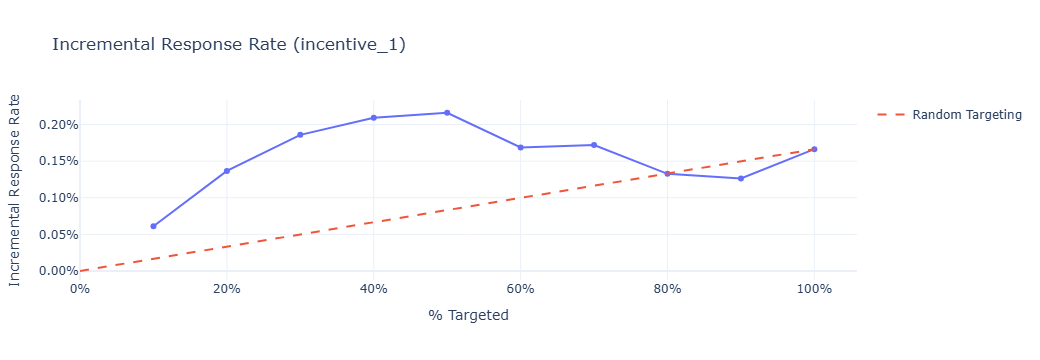

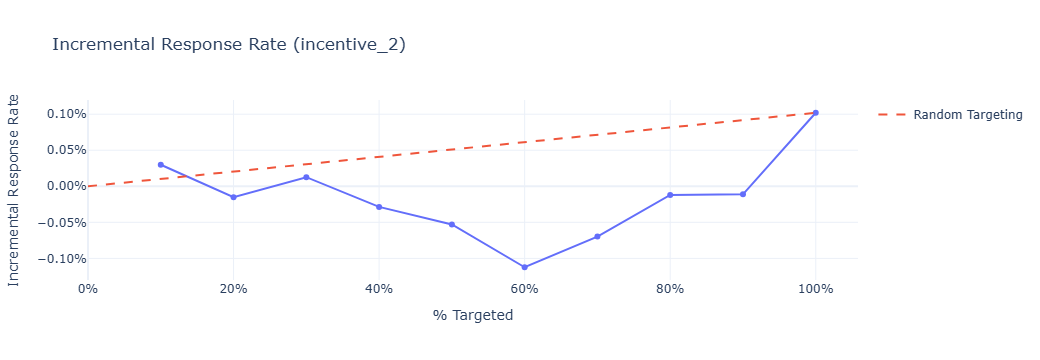

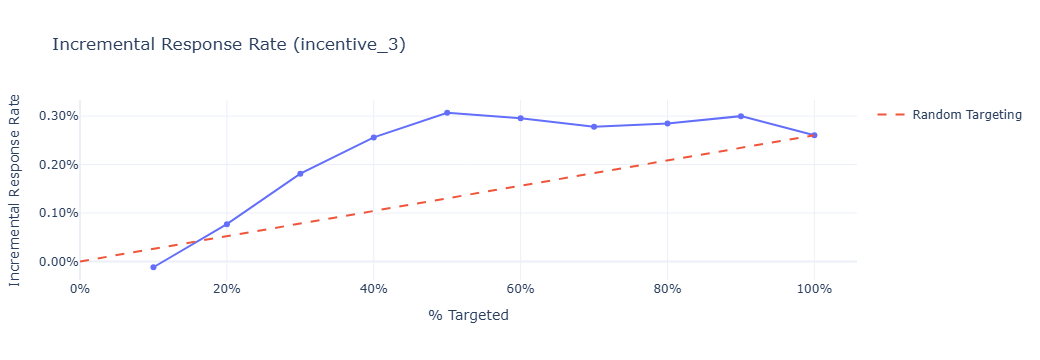

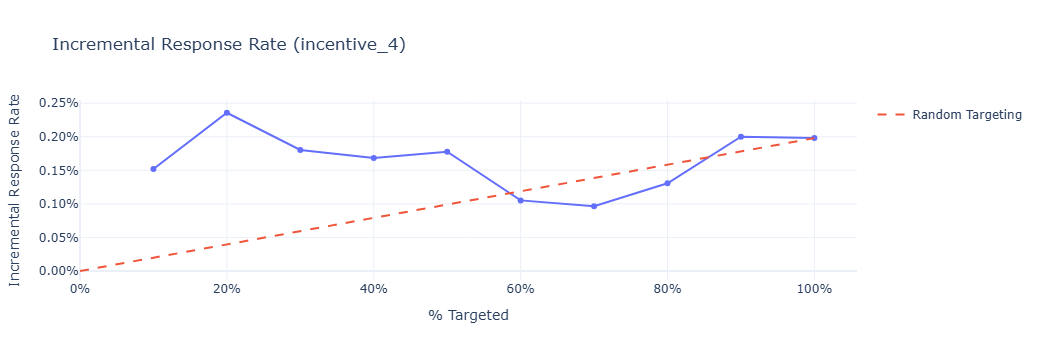

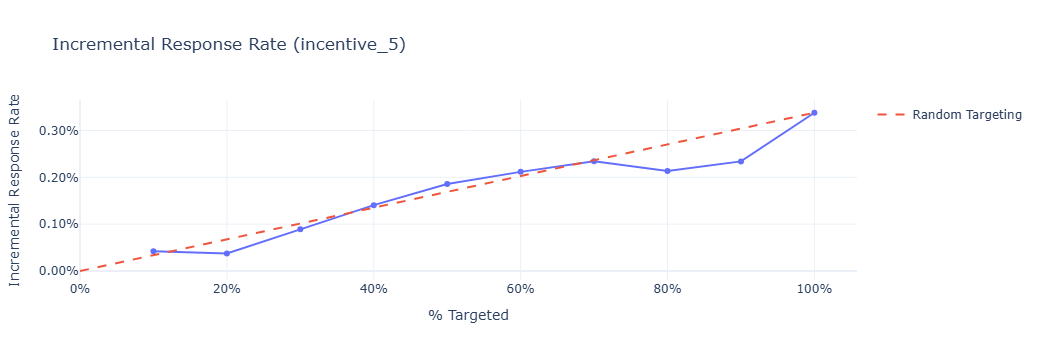

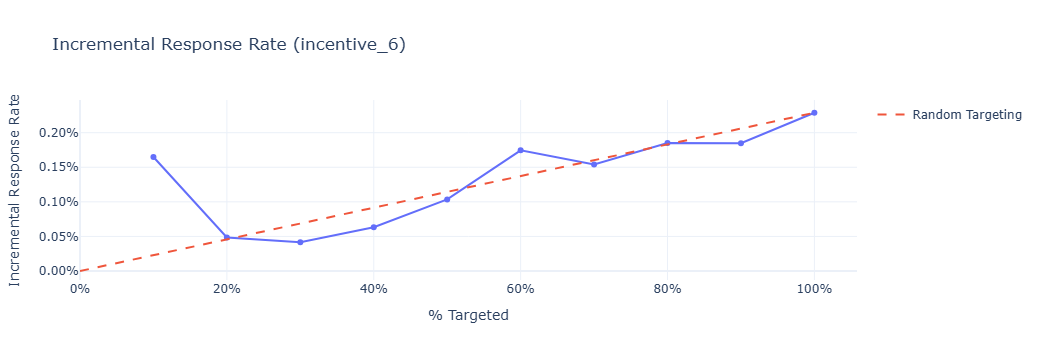

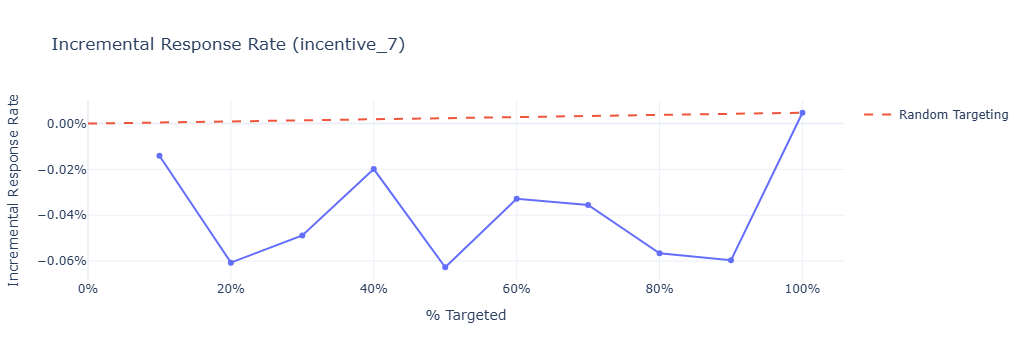

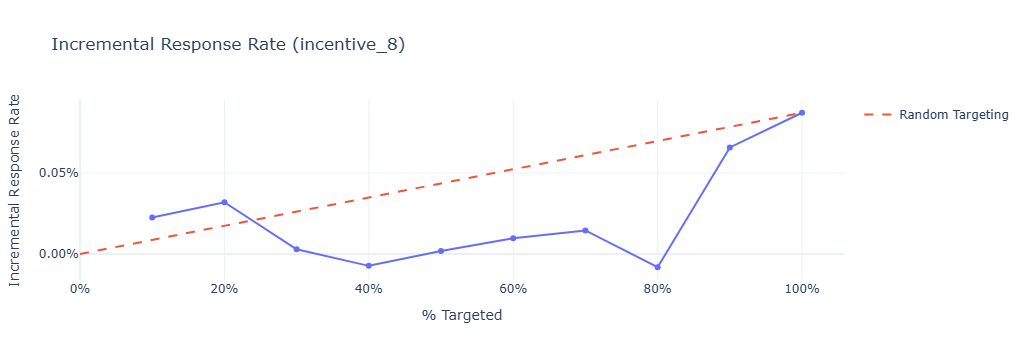

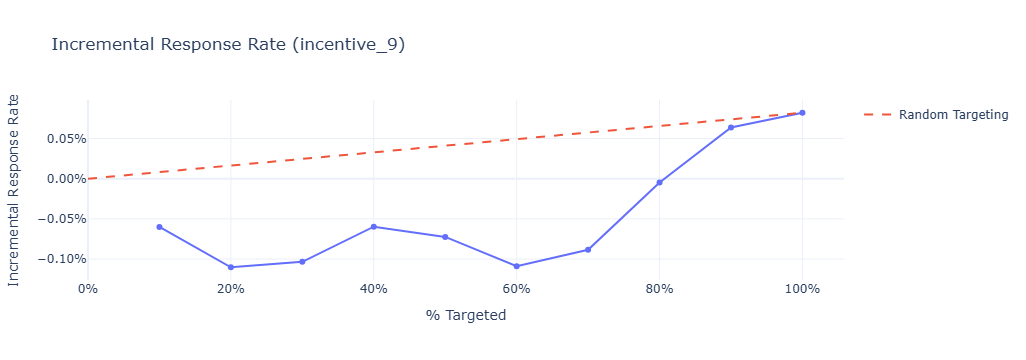

In [16]:
import plotly.io as pio
pio.renderers.default = "jupyterlab"
out_dir = Path("Output")
out_dir.mkdir(parents=True, exist_ok=True)

for k, qini_k in qini_bins.groupby("incentive_k", sort=True):
    fig = plot_incremental_response_rate(qini_k)

    incentive = f"incentive_{k}"

    # Add incentive number to the title
    fig.update_layout(
        title=f"Incremental Response Rate ({incentive})"
    )

    fig.write_html(out_dir / f"{incentive}_incremental_response_rate.html")

    fig.show()
